In [1]:
import autograd.numpy as np
import pandas as pd

from autograd import grad, hessian
from patsy import dmatrices
from scipy.optimize import minimize
from scipy.stats import norm

%matplotlib inline

# Data pre-processing

Read in the *NCCTG Lung Cancer* data from the R package [`survival`](https://cran.r-project.org/package=survival).

In [2]:
ovarian = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/survival/ovarian.csv', index_col=0)

Replace dots with underscores in column names.

In [3]:
ovarian.columns = ovarian.columns.str.replace('\\.', '_')

In [4]:
ovarian.head()

,futime,fustat,age,resid_ds,rx,ecog_ps
1,59,1,72.3315,2,1,1
2,115,1,74.4932,2,1,1
3,156,1,66.4658,2,1,2
4,421,0,53.3644,2,2,1
5,431,1,50.3397,2,1,1


# Exploratory data analysis

## Bar plot of censored vs dead

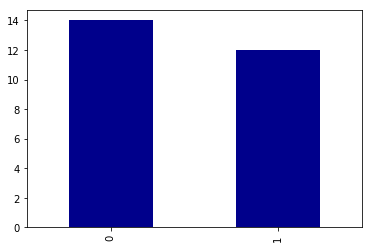

In [5]:
ovarian['fustat'].value_counts().sort_index().plot.bar(color='darkblue')

## Density plot of age

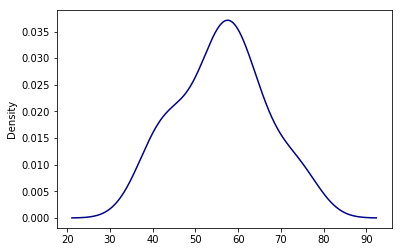

In [6]:
ovarian['age'].plot.density(color='darkblue')

## Bar plot of [ECOG Performance Status](https://training.seer.cancer.gov/followup/procedures/dataset/ecog.html)

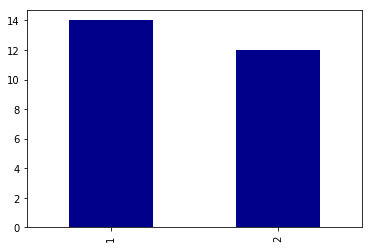

In [7]:
ovarian['ecog_ps'].value_counts().sort_index().plot.bar(color='darkblue')

# Modelling

Define the negative log-likehood function of the Weibull model.

In [8]:
def nll(parameters, scale, X, Y):
    if scale is None:
        beta, sigma = parameters[:-1], np.exp(parameters[-1])
    else:
        beta, sigma = parameters, scale  
    z = (np.log(Y[:, 0]) - np.dot(X, beta)) / sigma
    return np.sum(np.exp(z) - Y[:, 1] * (z - np.log(sigma)))

Define gradient and Hessian of the negative log-likehood w.r.t. `parameters` using [Autograd](https://github.com/HIPS/autograd).

In [9]:
nll_grad = grad(nll, 0)
nll_hess = hessian(nll, 0)

Define a function to perform model fitting and hypothesis testing on the parameters.

In [10]:
def fit(X, Y, scale=None, x0=None):
    if x0 is None:
        p = X.shape[1]
        if scale is None:
            p += 1
        x0 = np.zeros(p, dtype=np.double)
    solution = minimize(nll, x0, args=(scale, X, Y), method='Newton-CG', jac=nll_grad, hess=nll_hess)
    if not solution.success:
        raise RuntimeError(solution.message)
    results = {}
    results['coef'] = solution.x
    results['vcov'] = np.linalg.inv(nll_hess(solution.x, scale, X, Y))
    results['se'] = np.sqrt(np.diag(results['vcov']))
    results['z'] = results['coef'] / results['se']
    results['p'] = 2 * norm.cdf(-np.abs(results['z']))
    return results

Define a function to specify models using [`patsy`](https://patsy.readthedocs.io/) formulas.

In [11]:
def fit_formula(formula, data={}, scale=None):
    Y, X = dmatrices(formula, data=data)
    results = fit(np.asarray(X), np.asarray(Y), scale)
    index = X.design_info.column_names
    if scale is None:
        index.append('Log(scale)')
    return pd.DataFrame(results, index=index, columns=['coef', 'se', 'z', 'p'])

Estimate a Weibull model.

In [12]:
fit_formula('futime + fustat ~ ecog_ps + rx', ovarian)

,coef,se,z,p
Intercept,6.896693,1.177547,5.856829,4.717874e-09
ecog_ps,-0.385043,0.527002,-0.730629,4.650061e-01
rx,0.528645,0.529202,0.998949,3.178196e-01
Log(scale),-0.123442,0.252213,-0.489435,6.245341e-01


Compare with the output of `survreg` in R:
```
Call:
survreg(formula = Surv(futime, fustat) ~ ecog.ps + rx, data = ovarian)
             Value Std. Error      z        p
(Intercept)  6.897      1.178  5.857 4.72e-09
ecog.ps     -0.385      0.527 -0.731 4.65e-01
rx           0.529      0.529  0.999 3.18e-01
Log(scale)  -0.123      0.252 -0.489 6.25e-01

Scale= 0.884

Weibull distribution
Loglik(model)= -97.1   Loglik(intercept only)= -98
	Chisq= 1.74 on 2 degrees of freedom, p= 0.42
Number of Newton-Raphson Iterations: 5
n= 26
```

Fix `scale` to 1, corresponding to an exponential model.

In [13]:
fit_formula('futime + fustat ~ ecog_ps + rx', ovarian, scale=1)

,coef,se,z,p
Intercept,6.961838,1.321877,5.266629,1.389517e-07
ecog_ps,-0.433135,0.586994,-0.737886,4.605834e-01
rx,0.581503,0.586994,0.990646,3.218586e-01


Compare with the output of `survreg` in R:
```
Call:
survreg(formula = Surv(futime, fustat) ~ ecog.ps + rx, data = ovarian,
    dist = "exponential")
             Value Std. Error      z        p
(Intercept)  6.962      1.322  5.267 1.39e-07
ecog.ps     -0.433      0.587 -0.738 4.61e-01
rx           0.582      0.587  0.991 3.22e-01

Scale fixed at 1

Exponential distribution
Loglik(model)= -97.2   Loglik(intercept only)= -98
	Chisq= 1.67 on 2 degrees of freedom, p= 0.43
Number of Newton-Raphson Iterations: 4
n= 26
```